## ASTR496: Foundations of Data Science in Astronomy
Gautham Narayan
gsn@illinois.edu

### Midterm

In [1]:
# Q1: Maximum Likelihood Estimation for Stellar Parameters
# Estimating Temperature and Extinction from Multi-band Photometry

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import interp1d
import pandas as pd
from matplotlib import cm
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

#### **Problem Setup:**
#### - We observe a star in multiple photometric bands (B, V, R, I, J, H, K)
#### - We want to estimate: stellar temperature T and visual extinction A_V
#### - We assume we know the distance from e.g. Gaia (or fit for it separately)
####
#### **Model:**
#### For each filter λ, the observed magnitude is:
####
#### m_λ = M_λ(T) + 5*log₁₀(d/10) + A_V * R_λ
####
#### where:
#### - M_λ(T) = absolute magnitude in filter λ for temperature T
#### - d = distance in parsecs
#### - A_V = visual extinction
#### - R_λ = extinction coefficient for filter λ

### First, I have to give you a stellar model as a function of wavelength
### We'll use a Planck function i.e. a blackbody

In [2]:
def planck_function(wavelength, temperature):
    """
    Planck function for blackbody radiation
    wavelength in microns, temperature in Kelvin
    Returns relative flux (arbitrary units)
    """
    h = 6.626e-34  # Planck constant
    c = 3e8        # Speed of light
    k = 1.381e-23  # Boltzmann constant

    wl_m = wavelength * 1e-6  # Convert to meters

    # Planck function
    numerator = 2 * h * c**2
    denominator = wl_m**5 * (np.exp(h * c / (wl_m * k * temperature)) - 1)

    return numerator / denominator

### Next we need to define a photometric system - we'll use the Johnson(-Morgan) Kron-Cousins UBVRI filters and the reddening coefficients 
### and JHK for the IR, largely because you can look up the filter's effective wavelengths $\lambda_\text{eff}$ in microns and the reddening coefficients from something like Cardelli-Clayton-Mathis '89.

In [3]:
filters = {
    'B': {'lambda_eff': 0.44, 'R_lambda': 4.1},   # Blue
    'V': {'lambda_eff': 0.55, 'R_lambda': 3.1},   # Visual (reference)
    'R': {'lambda_eff': 0.64, 'R_lambda': 2.7},   # Red
    'I': {'lambda_eff': 0.79, 'R_lambda': 2.0},   # Near-IR
    'J': {'lambda_eff': 1.25, 'R_lambda': 0.9},   # IR
    'H': {'lambda_eff': 1.63, 'R_lambda': 0.6},   # IR
    'K': {'lambda_eff': 2.19, 'R_lambda': 0.4}    # IR
}

In [4]:
# here are some quick arrays of the filters, wavelengths and reddening coefficients.
filter_names = list(filters.keys())
wavelengths = np.array([filters[f]['lambda_eff'] for f in filter_names])
R_lambda = np.array([filters[f]['R_lambda'] for f in filter_names])

print(f"Photometric filters: {filter_names}")
print(f"Effective wavelengths (μm): {wavelengths}")
print(f"Extinction coefficients R_λ: {R_lambda}")

Photometric filters: ['B', 'V', 'R', 'I', 'J', 'H', 'K']
Effective wavelengths (μm): [0.44 0.55 0.64 0.79 1.25 1.63 2.19]
Extinction coefficients R_λ: [4.1 3.1 2.7 2.  0.9 0.6 0.4]


### Next, we need to reate the magnitudes of a star, given the spectral model 
### While we are using the Planck function as an approximation, we'll tie the fluxes to the obsserved flux of the 
### Sun itself, with $T_\text{eff}= 5778$K, and $M_V = 4.83$ (remember the absolute magnitude is defined for a distance of 10pc).

In [5]:
# Create stellar atmosphere model
def stellar_magnitude(temperature, filter_name, reference_temp=5778):
    """
    Calculate absolute magnitude for a star of given temperature
    Simplified model based on Planck function + calibration
    """
    wl = filters[filter_name]['lambda_eff']

    # Get flux ratio compared to solar temperature
    flux_star = planck_function(wl, temperature)
    flux_sun = planck_function(wl, reference_temp)
    flux_ratio = flux_star / flux_sun

    # Convert to magnitude difference (Sun has M_V = 4.83)
    # Add wavelength-dependent correction for more realism
    solar_magnitude = 4.83 + 0.5 * (wl - 0.55)  # Rough color correction

    magnitude = solar_magnitude - 2.5 * np.log10(flux_ratio)

    return magnitude

### Q1. As a function of temperature (3000-10,000K in 1000K steps) determine the B-V color

   Temperature (K)  B-V Color
0             3000   1.075612
1             4000   0.484747
2             5000   0.132543
3             6000  -0.099210
4             7000  -0.261670
5             8000  -0.380800
6             9000  -0.471213
7            10000  -0.541752


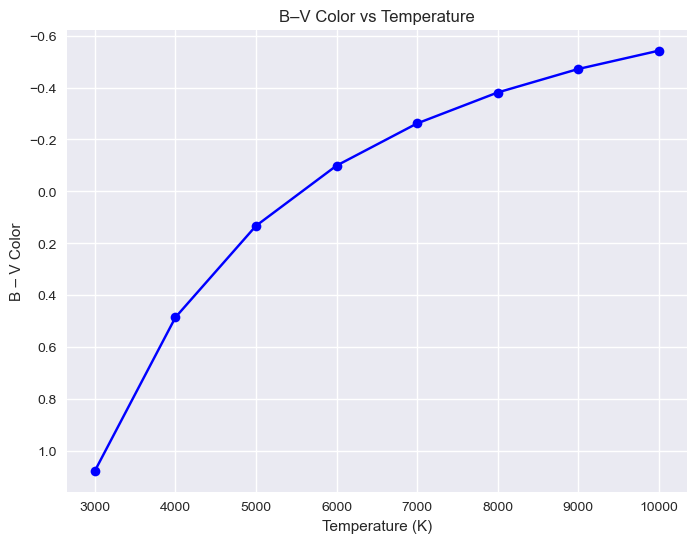

In [6]:
### YOUR ANSWER HERE
temperatures = np.arange(3000, 10001, 1000)
bv_colors = []

for T in temperatures:
    M_B = stellar_magnitude(T, 'B')
    M_V = stellar_magnitude(T, 'V')
    color = M_B - M_V 
    bv_colors.append(color)

df_bv = pd.DataFrame({
    'Temperature (K)': temperatures,
    'B-V Color': bv_colors
})

print(df_bv)

plt.figure(figsize=(8,6))
plt.plot(temperatures, bv_colors, marker='o', linestyle='-', color='blue')
plt.gca().invert_yaxis()
plt.title('B–V Color vs Temperature')
plt.xlabel('Temperature (K)')
plt.ylabel('B – V Color')
plt.grid(True)
plt.show()

### Next, I'll give you the "Truth" and some synthetic stellar data, with the true magnitudes of this star in each band using my `stellar_magnitude` but with the reddening and distance correction applied (you're going to have to do this)

In [7]:
# Generate a test star
TRUE_TEMP = 6500  # K
TRUE_A_V = 0.8    # magnitudes
TRUE_DISTANCE = 100    # parsecs


synthetic_star =  {'B': {'magnitude': 12.379, 'error': 0.02, 'true_magnitude': 12.369},
                   'V': {'magnitude': 11.752, 'error': 0.03, 'true_magnitude': 11.756},
                   'R': {'magnitude': 11.579, 'error': 0.04, 'true_magnitude': 11.553},
                   'I': {'magnitude': 11.225, 'error': 0.05, 'true_magnitude': 11.149},
                   'J': {'magnitude': 10.602, 'error': 0.06, 'true_magnitude': 10.616},
                   'H': {'magnitude': 10.592, 'error': 0.07, 'true_magnitude': 10.609},
                   'K': {'magnitude': 10.888, 'error': 0.08, 'true_magnitude': 10.762}}

### Q2.  
### OK, you know the drill 
### define a function that gives you the model magnitudes of the star given the temperature, extinction and distance
### define the log-likelihood
### Use `scipy.optimize` to get the best fit parameters for this star using maximum likelihood estimation
### Calculate the goodness of fit i.e. reduced chi-squared
### Calculate the Inverse Hessian Matrix and report the simple uncertainties on each parameter
### Which parameters are correlated strongly?

In [8]:
# Initial guess
initial_guess = [5500, 0.5, 75]  # Temperature, A_V, Distance


### YOUR ANSWER HERE

def model_magnitudes(params):
    T, A_V, d = params
    mags = {}
    for f in filters:
        M_lambda = stellar_magnitude(T, f)
        R_lambda = filters[f]['R_lambda']
        m_lambda = M_lambda + 5 * np.log10(d / 10) + A_V * R_lambda
        mags[f] = m_lambda
    return mags

def log_likelihood(params):
    model = model_magnitudes(params)
    lnL = 0
    for f in synthetic_star:
        m_obs = synthetic_star[f]['magnitude']
        m_err = synthetic_star[f]['error']
        lnL += -0.5 * ((m_obs - model[f])**2 / m_err**2 + np.log(2 * np.pi * m_err**2))
    return lnL

def neg_log_likelihood(params):
    return -log_likelihood(params)

result = minimize(neg_log_likelihood, initial_guess, method='Nelder-Mead')
best_params = result.x
print( best_params)

def reduced_chi_squared(params):
    model = model_magnitudes(params)
    chi2 = 0
    N = len(synthetic_star)
    k = len(params)
    for f in synthetic_star:
        m_obs = synthetic_star[f]['magnitude']
        m_err = synthetic_star[f]['error']
        chi2 += ((m_obs - model[f]) / m_err) ** 2
    return chi2 / (N - k)

chi2_red = reduced_chi_squared(best_params)
print(chi2_red)

def hessian(func, x0):
    n = len(x0)
    H = np.zeros((n, n))
    eps = np.sqrt(np.finfo(float).eps)
    for i in range(n):
        for j in range(n):
            x_ij1 = np.array(x0); x_ij2 = np.array(x0)
            x_ij3 = np.array(x0); x_ij4 = np.array(x0)
            x_ij1[i] += eps; x_ij1[j] += eps
            x_ij2[i] += eps; x_ij2[j] -= eps
            x_ij3[i] -= eps; x_ij3[j] += eps
            x_ij4[i] -= eps; x_ij4[j] -= eps
            H[i, j] = (func(x_ij1) - func(x_ij2) - func(x_ij3) + func(x_ij4)) / (4 * eps**2)
    return H

H = hessian(neg_log_likelihood, best_params)
cov = np.linalg.inv(H)
uncertainties = np.sqrt(np.diag(cov))
corr = cov / np.outer(uncertainties, uncertainties)

print(uncertainties)
print(corr)


[7.63993850e+03 9.42342349e-01 1.11839331e+02]
0.8271834158133246
[0.11475092 0.00415714 0.11312002]
[[ 1.          0.00961139 -0.02679979]
 [ 0.00961139  1.         -0.14999937]
 [-0.02679979 -0.14999937  1.        ]]


I do not think any of the parameters are strongly related. Temperature and extinction and distance have almost zero correlation. And A_V and distance have negative correlation.

### Q3.

### It is worth remembering the difference between Monte Carlo and Markov Chain Monte Carlo
### Using the same true parameters provided to you with Q2, generate 1000 random stars with the same true values, but different random seeds
### Repeat your analysis in Q2 for each of these 1000 stars, saving the results
### Use the results from this Monte Carlo process to determine a more robust uncertainty estimate, and measure the mean bias (i.e. how far are you from the truth) in parameter recovery

Monte Carlo mean recovered parameters [T, A_V, D]: [6.75383533e+03 7.89742745e-01 1.01461668e+02]
Monte Carlo standard deviation [σ_T, σ_A_V, σ_D]: [1.78713658e+03 1.97157623e-01 1.34714668e+01]
Bias (recovered - true): [ 2.53835335e+02 -1.02572546e-02  1.46166798e+00]


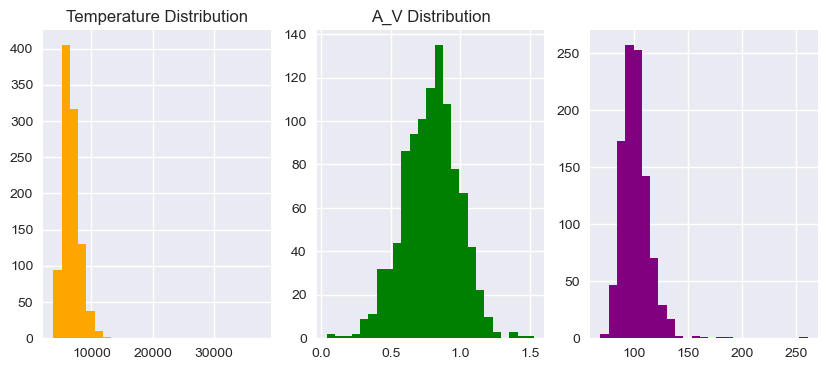

In [ ]:
### YOUR ANSWER HERE
n_stars = 1000
results = []

for i in range(n_stars):
    noisy_star = {}
    for f in synthetic_star:
        mag_true = synthetic_star[f]['true_magnitude']
        mag_err = synthetic_star[f]['error']
        mag_obs = np.random.normal(mag_true, mag_err)
        noisy_star[f] = {'magnitude': mag_obs, 'error': mag_err}

    def logL(params):
        model = model_magnitudes(params)
        lnL = 0
        for f in noisy_star:
            m_obs = noisy_star[f]['magnitude']
            m_err = noisy_star[f]['error']
            lnL += -0.5 * ((m_obs - model[f])**2 / m_err**2)
        return lnL

    res = minimize(lambda x: -logL(x), initial_guess, method='Nelder-Mead')
    results.append(res.x)

results = np.array(results)
mean_params = results.mean(axis=0)
std_params = results.std(axis=0)

print(mean_params)
print(std_params)

true_values = np.array([TRUE_TEMP, TRUE_A_V, TRUE_DISTANCE])
bias = mean_params - true_values
print(bias)

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.hist(results[:,0], bins=25, color='orange')
plt.title('Temperature Distribution')
plt.subplot(1,3,2)
plt.hist(results[:,1], bins=25, color='green')
plt.title('A_V Distribution')
plt.subplot(1,3,3)
plt.hist(results[:,2], bins=25, color='purple')
plt.show()


### Q4. 

### Finally, try this problem with a Markov Chain Monte Carlo but this time, incorporating a prior on the distance of 98 +/- 5 pc from synthetic Gaia, but repeating the anaysis three times - once with all filters, next with RIJHK and then with BVRIJ only.

#### Make reasonable choices for the number of walkers, steps, thinning etc. It's your responsibility to ensure the posteriors are well sampled.

### Show corner plots for all three cases in the same figure (you can try the `ChainConsumer` package)

### How do these results compare, and what happens to the extinction and temperature with fewer bands, and in the case of all filters, with your answer from Q2/Q3. 

100%|██████████| 2000/2000 [00:02<00:00, 701.82it/s]


Temperature  = 7079.268 ± 769.922
A_V          = 0.861 ± 0.112
Distance     = 106.909 ± 7.401


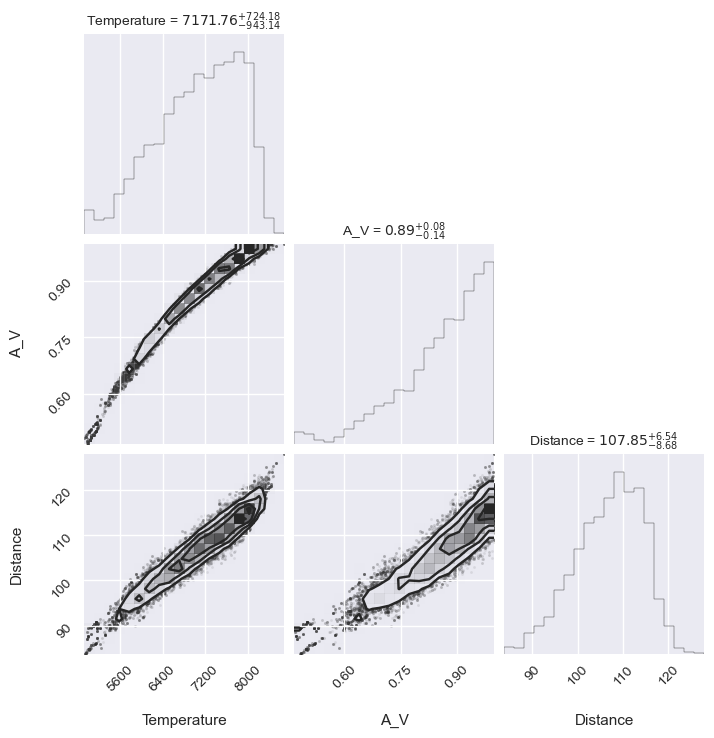

In [10]:
### YOUR ANSWER HERE

import emcee
import corner

def log_prior(params):
    T, A_V, D = params
    if 3000 < T < 10000 and 0.0 <= A_V <= 1.0 and 10 < D < 200:
        return 0.0 
    return -np.inf

def log_posterior(params):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params) 

ndim = 3
nwalkers = 24
initial_pos = initial_guess + 1e-3 * np.random.randn(nwalkers, ndim) 

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
sampler.run_mcmc(initial_pos, 2000, progress=True) 

samples = sampler.get_chain(discard=500, flat=True)

param_names = ["Temperature", "A_V", "Distance"]
for i, name in enumerate(param_names):
    mean_val = np.mean(samples[:, i])
    std_val = np.std(samples[:, i])
    print(f"{name:12s} = {mean_val:.3f} ± {std_val:.3f}")

fig = corner.corner(samples, labels=param_names,
                    show_titles=True, title_fmt=".2f", title_kwargs={"fontsize": 10})
plt.show()
